In [2]:
# To import functions from utils.py, which is in the parent diretory

import sys
import os

current_dir = os.path.dirname(os.path.abspath('__file__')) 

parent_dir = os.path.dirname(current_dir)

sys.path.append(parent_dir)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from collections import defaultdict
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from scipy.stats import randint, uniform
import joblib
from custom_imputer import ColumnwiseIterativeImputer
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore")

# Feature Engineering

By the analysis at the end of the `tree_models_with_lags` notebook, we found that the Patient's Most Recent History has great importance and that Time and Age also have some impact on the UPDRS score progression.

Therefore, we will primarily focus on creating features that can reflect more details about a patient's historical UPDRS score, while paying some attention to the interaction of time and age with historical UPDRS scores.


In [4]:
data = pd.read_csv("../3. EDA and data preprocessing/preprocessed_training_data.csv")

with open('../3. EDA and data preprocessing/time_dependent_clinical_features.txt', 'r') as file:
    clinical_feature_time_dependent = file.readlines()
clinical_feature_time_dependent = [item.strip() for item in clinical_feature_time_dependent]

with open('../3. EDA and data preprocessing/static_clinical_features.txt', 'r') as file:
    clinical_feature_non_time_dependent = file.readlines()
clinical_feature_non_time_dependent = [item.strip() for item in clinical_feature_non_time_dependent]

In [10]:
updrs_cols = ['updrs_1', 'updrs_2', 'updrs_3']
cols_to_lag = updrs_cols + clinical_feature_time_dependent

data = data.sort_values(['participant_id', 'visit_month'])


# create more lags

for lag in [1, 2, 3, 4, 5, 6]:
    for col in cols_to_lag:
        data[f'{col}_lag_{lag}'] = data.groupby('participant_id')[col].shift(lag)


lagged_cols = [col for col in data.columns if '_lag_' in col]


# Rate of Change / Slopes
print("Adding change rate features...")
for score in updrs_cols:

    data[f'{score}_slope_1'] = data[f'{score}_lag_1'] - data[f'{score}_lag_2']

    data[f'{score}_slope_2'] = data[f'{score}_lag_2'] - data[f'{score}_lag_3']

    data[f'{score}_slope_mean'] = (data[f'{score}_lag_1'] - data[f'{score}_lag_3']) / 2


# Rolling Averages
print("Adding rolling average features...")
for score in updrs_cols:

    data[f'{score}_mean_lags'] = data[lagged_cols].mean(axis=1)

    data[f'{score}_weighted'] = (
        0.6 * data[f'{score}_lag_1'] +
        0.3 * data[f'{score}_lag_2'] +
        0.1 * data[f'{score}_lag_3']
    )

# Volatility Features
print("Adding volatility features...")
for score in updrs_cols:

    data[f'{score}_lag_std'] = data[lagged_cols].std(axis=1)

    data[f'{score}_lag_range'] = data[lagged_cols].max(axis=1) - data[lagged_cols].min(axis=1)

# Longitudinal Summaries
print("Adding longitudinal summary features...")
for score in updrs_cols:

    data[f'{score}_trend'] = data.groupby('participant_id')[f'{score}_lag_1'].transform(
        lambda x: x.diff().mean()
    )

# Time-Adjusted Features
print("Adding time-adjusted features...")
for score in updrs_cols:

    data[f'{score}_time_adj'] = data[f'{score}_lag_1'] / (data['visit_month'] + 2)

# Patient age progression
data['age_progression'] = data['age_at_baseline'] + data['visit_month'] / 12


# interaction feature
data['age_x_visit_month'] = data['age_at_baseline'] * (data['visit_month'] )

# UPDRS Ratios
print("Adding UPDRS ratio features...")
data['motor_ratio'] = data['updrs_3_lag_1'] / (
    data['updrs_1_lag_1'] +
    data['updrs_2_lag_1'] +
    1e-5  # Prevents division by zero
)


lagged_feature_cols = [col for col in data.columns if '_lag_' in col]

trend_feature_cols = [col for col in data.columns if any(x in col for x in ['slope', 'mean', 'weighted', 'std', 'range', 'adj', 'ratio', 'trend'])]

final_feature_cols = clinical_feature_non_time_dependent + lagged_feature_cols + trend_feature_cols + ["age_x_visit_month"]

# avoid duplicated elements arising from both lagged_feature_cols and trend_feature_cols
final_feature_cols = list(dict.fromkeys(final_feature_cols))

updrs_lagged_cols = [col for col in data.columns if ('_lag_' in col) and ("updrs" in col)]

other_lagged_cols = [col for col in final_feature_cols if col in lagged_feature_cols and col not in updrs_lagged_cols]

non_lagged_cols = [col for col in final_feature_cols if (col not in lagged_feature_cols) and (col not in trend_feature_cols)]
# defragmentation to improve performance
data=data.copy()


Adding change rate features...
Adding rolling average features...
Adding volatility features...
Adding longitudinal summary features...
Adding time-adjusted features...
Adding UPDRS ratio features...


##### Cross Validation

In [ ]:
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

mae_results = defaultdict(list)
cv_split_generator = gkf.split(data, groups=data["participant_id"])

imputation_recipe = {
    'updrs_3_lag_1': ['updrs_3_lag_2','updrs_3_lag_3', 'updrs_1_lag_2', 'updrs_1_lag_3', 'updrs_2_lag_3',],
    
    'updrs_2_lag_1': ['updrs_3_lag_3','updrs_3_lag_3', 'updrs_1_lag_2', 'updrs_3_lag_3', 'updrs_3_lag_3',],

    'updrs_3_lag_2': ['updrs_3_lag_3','updrs_2_lag_3', 'updrs_1_lag_3'],

    'updrs_2_lag_2': ['updrs_3_lag_3','updrs_2_lag_3', 'updrs_1_lag_3'],

    'updrs_3_lag_3': [],

    'updrs_2_lag_3': []
}

for fold, (train_idx, test_idx) in enumerate(cv_split_generator):
    train_fold = data.iloc[train_idx]
    holdout_fold = data.iloc[test_idx]

    X_train, y_train = train_fold[final_feature_cols], train_fold[updrs_cols]
    X_holdout, y_holdout = holdout_fold[final_feature_cols], holdout_fold[updrs_cols]

    preprocessor = ColumnTransformer(
        transformers=[
            ('imputer_on_lagged_updrs', ColumnwiseIterativeImputer(imputation_mapping=imputation_recipe), updrs_lagged_cols),
            ('imputer_on_other_lagged_features', SimpleImputer(strategy='constant', fill_value=0), other_lagged_cols),
            ('clinical_imputer', SimpleImputer(strategy='median'), non_lagged_cols)
        ],
        remainder='passthrough'
    )

    preprocessor.fit(X_train)

    X_train_imputed = pd.DataFrame(preprocessor.transform(X_train), columns=final_feature_cols, index=X_train.index)
    X_holdout_imputed = pd.DataFrame(preprocessor.transform(X_holdout), columns=final_feature_cols, index=X_holdout.index)


    y_train_clean = y_train.dropna()
    X_train_clean = X_train_imputed.loc[y_train_clean.index]



    lgbm_estimator = lgb.LGBMRegressor(
        objective='regression_l1',
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        n_jobs=-1,
        random_state=42,
        verbose=-1,
    )
    model = MultiOutputRegressor(lgbm_estimator)

    model.fit(X_train_clean, y_train_clean)


    predictions_array = model.predict(X_holdout_imputed)
    predictions_df = pd.DataFrame(predictions_array, index=X_holdout.index, columns=updrs_cols)

    for col in updrs_cols:
        actual_values = y_holdout[col]
        predicted_values = predictions_df[col]

        valid_indices = actual_values.notna()
        mae = mean_absolute_error(actual_values[valid_indices], predicted_values[valid_indices])

        mae_results[col].append(mae)

In [14]:
print("\n--- Cross-Validation Results for LGBM w/ Lags ---")
for col, scores in mae_results.items():
    avg_mae = np.mean(scores)
    std_mae = np.std(scores)
    print(f"Average MAE for {col}: {avg_mae:.4f} (+/- {std_mae:.4f})")


--- Cross-Validation Results for LGBM w/ Lags ---
Average MAE for updrs_1: 2.5077 (+/- 0.0327)
Average MAE for updrs_2: 2.4030 (+/- 0.0376)
Average MAE for updrs_3: 5.2782 (+/- 0.1069)


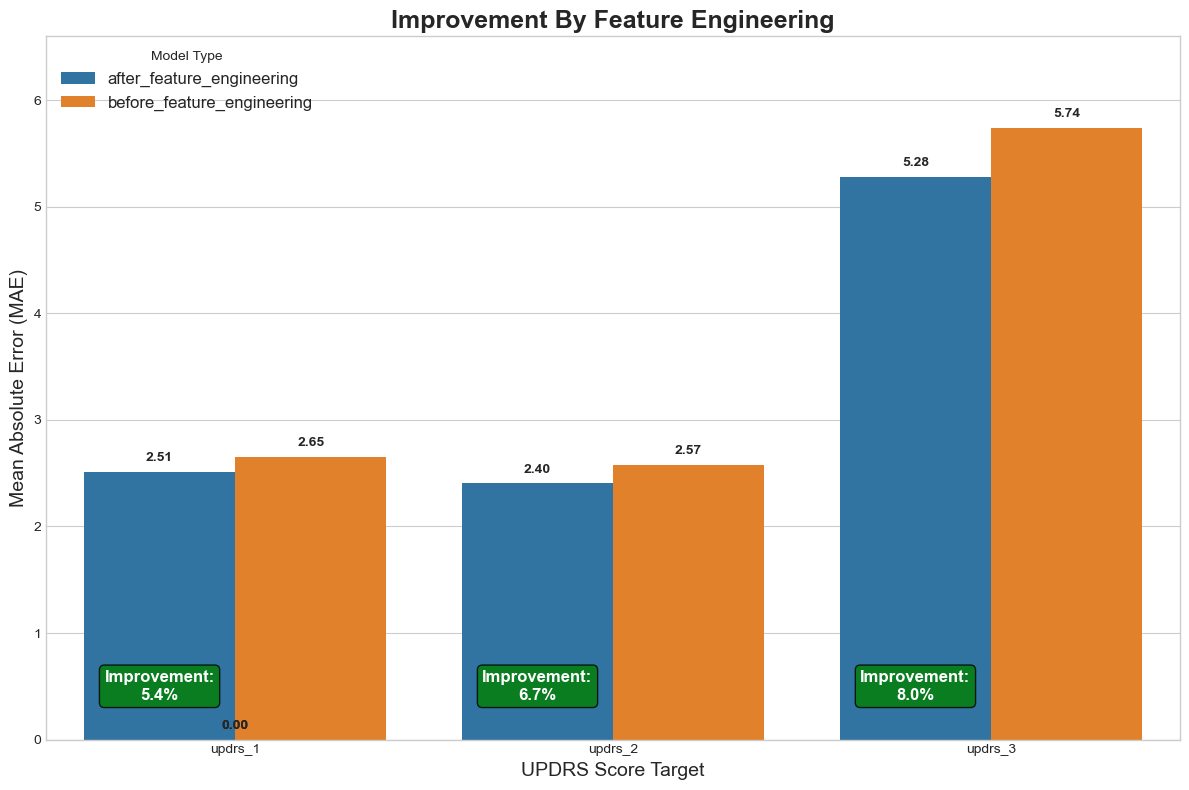

In [15]:
mae_averages = {col: np.mean(np.array([mae_results[col]])) for col in mae_results}

lgbm_after_FE = pd.DataFrame([mae_averages])

lgbm_after_FE["status"] = "after_feature_engineering"

lgbm_before_FE = pd.read_csv("mae_for_tree_models_with_lags.csv")

lgbm_before_FE = lgbm_before_FE.loc[[2]]

lgbm_before_FE['status']="before_feature_engineering"

lgbm_before_FE=lgbm_before_FE.drop(["model", "Model"], axis=1)

mae_comparison = pd.concat([lgbm_after_FE, lgbm_before_FE], ignore_index = True)

df = mae_comparison.melt(id_vars='status', var_name='target', value_name='error').dropna()


plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(data=df, x='target', y='error', hue='status', ax=ax)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}',           # Format the MAE score to 2 decimal places
        (p.get_x() + p.get_width() / 2., p.get_height()), # Position of the text
        ha='center',                       # Horizontal alignment
        va='center',                       # Vertical alignment
        xytext=(0, 10),                    # Offset the text slightly above the bar
        textcoords='offset points',
        fontweight='bold'
    )



baseline_maes = df[df['status'] == 'before_feature_engineering']['error'].values
final_maes = df[df['status'] == 'after_feature_engineering']['error'].values
improvements = ((baseline_maes - final_maes) / baseline_maes) * 100

x_coords = [p.get_x() + p.get_width() / 2. for p in ax.patches[:3]]

for i, improvement in enumerate(improvements):
    ax.annotate(
        f'Improvement:\n{improvement:.1f}%',
        xy=(x_coords[i], 0.5), # Place it low on the plot for clarity
        ha='center',
        va='center',
        color='white',
        fontweight='bold',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="green", ec="black", lw=1, alpha=0.8)
    )

# --- 4. Final Touches ---
ax.set_title('Improvement By Feature Engineering', fontsize=18, fontweight='bold')
ax.set_ylabel('Mean Absolute Error (MAE)', fontsize=14)
ax.set_xlabel('UPDRS Score Target', fontsize=14)
ax.legend(title='Model Type', fontsize=12)
ax.set_ylim(0, df['error'].max() * 1.15)

plt.tight_layout()
plt.show()

### Observation:
The model is improved, though less compared to the improvement from the baseline model to tree models with lags.

### Analysis:
The engineering features are valuable, but they are refining the core knowledge the model already gained from the simple lags. They help the model make a better decision, but the fundamental information was already contained in the lags. Combined with the knowledge of how tree models work, this phenomena are expected.


--- Feature Importance (from last fold's model) ---
Top 20 Features (Averaged Across UPDRS Targets):
                                                    updrs_1  ...  average_importance
updrs_3_trend                                           674  ...         1482.333333
sbr_putamen_r_lag_1                                     649  ...         1439.333333
updrs_1_time_adj                                        750  ...         1285.333333
updrs_1_weighted                                        617  ...         1130.000000
roi1_left_rostral_Eigenvalue2                           479  ...          991.666667
test_value_Plasma_Macrophage migration inhibito...      661  ...          984.333333
updrs_3_slope_2                                         822  ...          931.000000
updrs_2_trend                                          1132  ...          879.333333
updrs_2_mean_lags                                       896  ...          870.333333
updrs_3_mean_lags                               

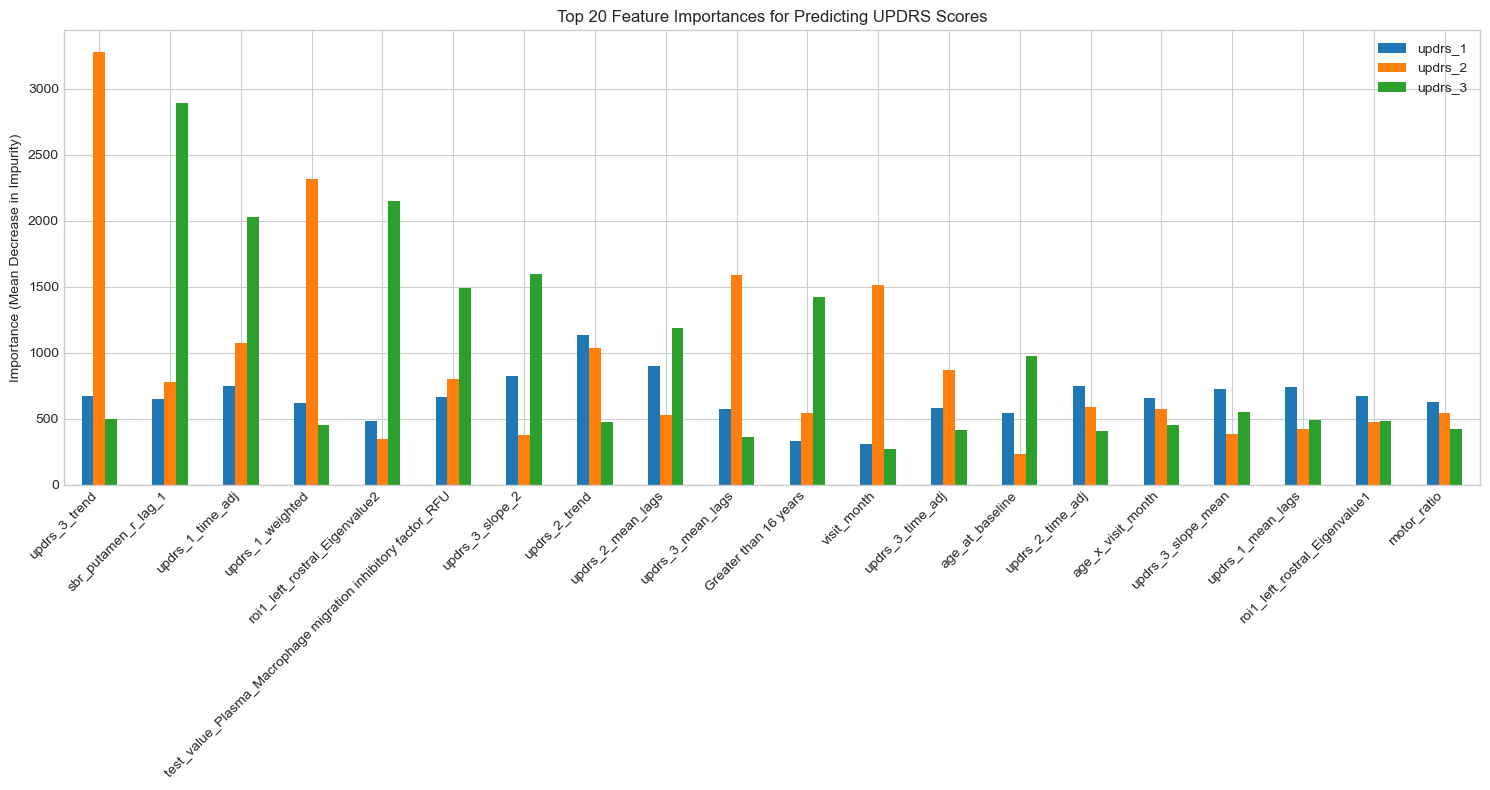

In [16]:
# Extract feature importance from the model trained on the LAST fold
print("\n--- Feature Importance (from last fold's model) ---")
importance_df = pd.DataFrame(index=final_feature_cols)

for i, estimator in enumerate(model.estimators_):
    target_name = updrs_cols[i]
    importances = estimator.feature_importances_
    importance_df[target_name] = importances

importance_df['average_importance'] = importance_df.mean(axis=1)
top_features = importance_df.sort_values(by='average_importance', ascending=False).head(20)
importance_df.to_csv("feature_importance_after_engineering.csv")


print("Top 20 Features (Averaged Across UPDRS Targets):")
print(top_features)

# Visualize the top features
top_features[updrs_cols].plot(kind='bar', figsize=(15, 8))
plt.title('Top 20 Feature Importances for Predicting UPDRS Scores')
plt.ylabel('Importance (Mean Decrease in Impurity)')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Observation:

Compared with the feature importance for LGBM trained on the un-engineered features, we saw more historical-record-related features here, further confirming our intuition that the trend or growth is the key signals in a time series dataset.

# Hyperparameter tuning


In [58]:
importance_df = pd.read_csv("feature_importance_after_engineering.csv")
if 'Unnamed: 0' in importance_df.columns:
    importance_df.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)

N_TOP_FEATURES = 75
final_feature_cols_selected = importance_df.sort_values(
    by='average_importance',
    ascending=False
).head(N_TOP_FEATURES)['feature'].tolist()

# to make sure the mice imputer work
for col in updrs_lagged_cols:
    if col not in final_feature_cols_selected:
        final_feature_cols_selected.append(col)

print(f"Proceeding with the top {len(final_feature_cols_selected)} features for tuning.")

data_cleaned = data.dropna(subset=updrs_cols).copy()

X = data_cleaned[final_feature_cols_selected]
y = data_cleaned[updrs_cols]
groups = data_cleaned['participant_id']

Proceeding with the top 79 features for tuning.


### Align with the selected features

In [59]:
updrs_lagged_cols = [col for col in updrs_lagged_cols if col in final_feature_cols_selected]

other_lagged_cols = [col for col in other_lagged_cols if col in final_feature_cols_selected]

non_lagged_cols = [col for col in non_lagged_cols if col in final_feature_cols_selected]

In [60]:
cv_strategy = GroupKFold(n_splits=5)

preprocessor = ColumnTransformer(
        transformers=[
            ('imputer_on_lagged_updrs', ColumnwiseIterativeImputer(imputation_mapping=imputation_recipe), updrs_lagged_cols),
            ('imputer_on_other_lagged_features', SimpleImputer(strategy='constant', fill_value=0), other_lagged_cols),
            ('clinical_imputer', SimpleImputer(strategy='median'), non_lagged_cols)
        ],
        remainder='passthrough'
    )

lgbm_estimator = lgb.LGBMRegressor(objective='regression_l1', random_state=42, n_jobs=1, verbose=-1)

multi_output_model = MultiOutputRegressor(lgbm_estimator)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', multi_output_model)
])


param_dist = {
    'model__estimator__n_estimators': randint(200, 1500),
    'model__estimator__learning_rate': uniform(0.01, 0.08),
    'model__estimator__num_leaves': randint(20, 60),
    'model__estimator__max_depth': randint(5, 15),
    'model__estimator__reg_alpha': uniform(0, 1),
    'model__estimator__reg_lambda': uniform(0, 1),
    'model__estimator__colsample_bytree': uniform(0.6, 0.4),
    'model__estimator__subsample': uniform(0.6, 0.4),
}

### Run Randomized Search with Cross-Validation

In [61]:
print("\nStarting Randomized Search for LightGBM Hyperparameters...")


neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

random_search = RandomizedSearchCV(
    estimator=pipeline,  
    param_distributions=param_dist,
    n_iter=10,  
    cv=cv_strategy, 
    scoring=neg_mae_scorer,
    verbose=2,
    n_jobs=-1, 
    random_state=42
)

random_search.fit(X, y, groups=groups)


Starting Randomized Search for LightGBM Hyperparameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,Pipeline(step...erbose=-1)))])
,param_distributions,"{'model__estimator__colsample_bytree': <scipy.stats....002562056EEA0>, 'model__estimator__learning_rate': <scipy.stats....00256204E86E0>, 'model__estimator__max_depth': <scipy.stats....00256204E8620>, 'model__estimator__n_estimators': <scipy.stats....00256204EBAA0>, ...}"
,n_iter,10
,scoring,make_scorer(m...hod='predict')
,n_jobs,-1
,refit,True
,cv,GroupKFold(n_...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


### View the Results

In [63]:
print("\n--- Hyperparameter Tuning Complete ---")
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation score (Negative MAE): {-random_search.best_score_:.4f}")

best_lgbm_model_pipeline = random_search.best_estimator_

print("\nBest LightGBM model pipeline is now trained and ready for use.")


--- Hyperparameter Tuning Complete ---
Best parameters found: {'model__estimator__colsample_bytree': np.float64(0.6733618039413735), 'model__estimator__learning_rate': np.float64(0.03433937943676302), 'model__estimator__max_depth': 10, 'model__estimator__n_estimators': 452, 'model__estimator__num_leaves': 44, 'model__estimator__reg_alpha': np.float64(0.2912291401980419), 'model__estimator__reg_lambda': np.float64(0.6118528947223795), 'model__estimator__subsample': np.float64(0.6557975442608167)}
Best cross-validation score (Negative MAE): 3.3972

Best LightGBM model pipeline is now trained and ready for use.


### Re-evaluate the Best Model to Get Per-Target MAE Scores

In [64]:
print("\n--- Re-evaluating best model to get per-target MAE ---")


best_model_pipeline = random_search.best_estimator_

mae_results_best_model = defaultdict(list)

cv_strategy = GroupKFold(n_splits=5)

cv_split_generator = cv_strategy.split(X, y, groups=groups)

for fold, (train_idx, test_idx) in enumerate(cv_split_generator):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_holdout, y_holdout = X.iloc[test_idx], y.iloc[test_idx]

    best_model_pipeline.fit(X_train, y_train)

    predictions_array = best_model_pipeline.predict(X_holdout)
    predictions_df = pd.DataFrame(predictions_array, index=y_holdout.index, columns=updrs_cols)

    for col in updrs_cols:
        actual_values = y_holdout[col]
        predicted_values = predictions_df[col]
        
        mae = mean_absolute_error(actual_values, predicted_values)
        mae_results_best_model[col].append(mae)

print("\n--- Final Cross-Validated MAE for Best Tuned Model (Per Target) ---")
for col, scores in mae_results_best_model.items():
    avg_mae = np.mean(scores)
    std_mae = np.std(scores)
    print(f"Average MAE for {col}: {avg_mae:.4f} (+/- {std_mae:.4f})")


--- Re-evaluating best model to get per-target MAE ---

--- Final Cross-Validated MAE for Best Tuned Model (Per Target) ---
Average MAE for updrs_1: 2.5129 (+/- 0.0255)
Average MAE for updrs_2: 2.3970 (+/- 0.0345)
Average MAE for updrs_3: 5.2817 (+/- 0.1114)


## Observation

The improvement in terms of mean absolute error is minor. 


## Analysis

LightGBM is a very robust algorithm that performs very well with the chosen hyperparameter. There wasn't much "hidden" performance left for the tuning to find.

## 6. Output the model with the best hyperparameter

In [ ]:
joblib.dump(best_lgbm_model_pipeline, 'lgbm_model.pkl')

['lgbm_model.pkl']